In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import load_img
from keras.optimizers import Adam, SGD

from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

import os

Using TensorFlow backend.


# Gobal parameters

In [2]:
# Fixed for our Hot Dog & Pizza classes
NUM_CLASSES = 2

# Fixed for Hot Dog & Pizza color images
CHANNELS = 3

IMAGE_RESIZE = 227
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 25
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 128
BATCH_SIZE_VALIDATION = 64

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 1500 / BATCH_SIZE_TRAINING
STEPS_PER_EPOCH_VALIDATION = 300 / BATCH_SIZE_VALIDATION

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

# Work directory to save the checkpoints
WORK_FOLDER = 'working'

# Checkpoint file name
CHECKPOINT_FILE = 'best.hdf5'

# Weights file name
WEIGHTS_FILE = 'best_weights.h5'

In [3]:
# Base folder path for the Hot Dog & Pizza classification images
BASE_FOLDER_PATH = os.path.join('datasets', 'hotdog_pizza')

# The path to the training images
TRAIN_FOLDER_PATH = os.path.join(BASE_FOLDER_PATH, 'train')

# The path to the validation images
VALIDATION_FOLDER_PATH = os.path.join(BASE_FOLDER_PATH, 'valid')

# The path to the test images
TEST_FOLDER_PATH = os.path.join(BASE_FOLDER_PATH, 'test')

# Checkpoint file path
CHECKPOINT_FILE_PATH = os.path.join(WORK_FOLDER, CHECKPOINT_FILE)

# Weights file path
WEIGHTS_FILE_PATH = os.path.join(WORK_FOLDER, WEIGHTS_FILE)

In [4]:
read = lambda image_name: np.asarray(load_img(image_name, target_size=(224, 224)))

def read_images(image_path):
    image_names = os.listdir(image_path)
    image_paths = [os.path.join(image_path, image_name) for image_name in image_names]
    images = np.array([read(image_path) for image_path in image_paths], dtype='uint8')
    return images

In [5]:
class_path = os.path.join(TRAIN_FOLDER_PATH, 'hot_dog')

In [6]:
images = read_images(class_path)

In [7]:
images[0].shape

(224, 224, 3)

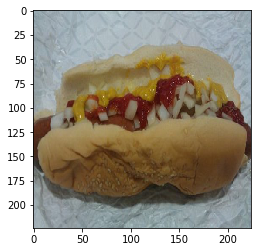

In [8]:
plt.imshow(images[45], interpolation='nearest')

In [9]:
#Instantiate an empty model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(227,227,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(4096, input_shape=(227*227*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))

# 2nd Fully Connected Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
activation_2 (Activation)    (None, 27, 27, 256)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 384)       885120    
__________

In [11]:
lr = 1e-3
adam_optimizer = Adam(lr=lr)
sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)

In [12]:
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
image_size = IMAGE_RESIZE

train_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                    rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)

test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                    rescale=1./255)

train_generator = train_data_generator.flow_from_directory(
        TRAIN_FOLDER_PATH,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='binary')

validation_generator = test_data_generator.flow_from_directory(
        VALIDATION_FOLDER_PATH,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='binary')

Found 1500 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [14]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(128, 12, 64, 5)

In [15]:
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)

cb_checkpointer = ModelCheckpoint(filepath = CHECKPOINT_FILE_PATH, monitor = 'val_loss', save_best_only = True, mode = 'auto')

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

In [ ]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[learning_rate_reduction, cb_checkpointer],
        verbose=1
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
12/11 [==============================] - 147s 12s/step - loss: 1.2490 - acc: 0.5220 - val_loss: 0.6851 - val_acc: 0.5067
Epoch 2/25
12/11 [==============================] - 138s 12s/step - loss: 0.6757 - acc: 0.6012 - val_loss: 0.6349 - val_acc: 0.6700
Epoch 3/25
12/11 [==============================] - 111s 9s/step - loss: 0.7594 - acc: 0.6360 - val_loss: 0.6524 - val_acc: 0.5967
Epoch 4/25
12/11 [==============================] - 132s 11s/step - loss: 0.6686 - acc: 0.5753 - val_loss: 0.6803 - val_acc: 0.5967
Epoch 5/25
12/11 [==============================] - 142s 12s/step - loss: 0.6588 - acc: 0.6295 - val_loss: 0.6287 - val_acc: 0.6733
Epoch 6/25
12/11 [==============================] - 119s 10s/step - loss: 0.6369 - acc: 0.6496 - val_loss: 0.6042 - val_acc: 0.6633
Epoch 7/25
12/11 [==============================] - 117s 10s/step - loss: 0.6068 - acc: 0.6814 - val_loss: 0.6241 - val_acc: 0.6667
Epoch 8/25
 1/11 [=>.........

In [17]:
model.save_weights(WEIGHTS_FILE_PATH)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


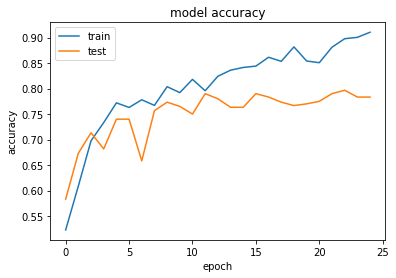

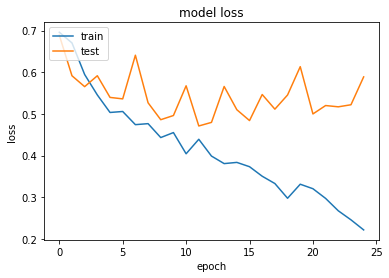

In [17]:
# list all data in history
print(fit_history.history.keys())
# summarize history for accuracy
plt.plot(fit_history.history['acc'])
plt.plot(fit_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
def predict_class(model, image):
    scaled_image = image/255.
    y_pred = model.predict_classes([[scaled_image]])
    confidence = model.predict([[scaled_image]])
    print("Predicted class:")
    print(y_pred)
    print(confidence)
    
    if y_pred[0] == 1:
        print("PIZZA")
    else:
        print("HOTDOG")

In [19]:
test_pizza_path = os.path.join(TEST_FOLDER_PATH, 'pizza')
test_hotdog_path = os.path.join(TEST_FOLDER_PATH, 'hot_dog')

In [20]:
pizza_images = read_images(test_pizza_path)
hotdog_images = read_images(test_hotdog_path)

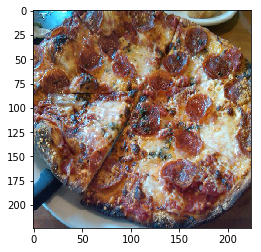

In [21]:
plt.imshow(pizza_images[10], interpolation='nearest')

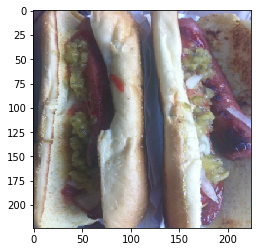

In [29]:
plt.imshow(hotdog_images[20], interpolation='nearest')

In [31]:
predict_class(model, hotdog_images[20])

Predicted class:
[0]
[[0.77515537 0.22472113]]
HOTDOG


In [26]:
predict_class(model, pizza_images[10])

Predicted class:
[1]
[[0.01727939 0.9832786 ]]
PIZZA
